<img src="4749_01_01.png" style="text-align:center; width:50%">

$$\begin{pmatrix}
0  &1/2  & 0   & 0    & 0   & 0   & 0   & 0 \\
1  & 0   &1/2  &1/2   & 0   & 0   & 0   & 0 \\
0  & 0   & 0   & 0    & 0   & 0   &1/3  & 0 \\
0  &1/2  & 0   & 0    & 0   & 1   &1/3  & 0 \\
0  & 0   &1/2  & 0    & 0   & 0   & 0   & 0 \\
0  & 0   & 0   & 0    & 0   & 0   & 0   &1/2\\
0  & 0   & 0   & 0    &1/2  & 0   & 0   &1/2\\
0  & 0   & 0   &1/2   &1/2  & 0   &1/3  &0
\end{pmatrix}$$ 

In [1]:
import numpy as np, matplotlib.pyplot as plt, scipy.linalg as spla, scipy.sparse as spsp, scipy.sparse.linalg as spspla

np.set_printoptions(suppress=True, precision=3)

cols = np.array([0,1,1,2,2,3,3,4,4,5,6,6,6,7,7])
rows = np.array([1,0,3,1,4,1,7,6,7,3,2,3,7,5,6])
data = np.array([1., 0.5, 0.5, 0.5, 0.5, 
                 0.5, 0.5, 0.5, 0.5, 1., 
                 1./3, 1./3, 1./3, 0.5, 0.5])

T = np.zeros((8,8))
T[rows,cols] = data

In [2]:
G = (1-0.15) * T + 0.15/8
print G

[[ 0.019  0.444  0.019  0.019  0.019  0.019  0.019  0.019]
 [ 0.869  0.019  0.444  0.444  0.019  0.019  0.019  0.019]
 [ 0.019  0.019  0.019  0.019  0.019  0.019  0.302  0.019]
 [ 0.019  0.444  0.019  0.019  0.019  0.869  0.302  0.019]
 [ 0.019  0.019  0.444  0.019  0.019  0.019  0.019  0.019]
 [ 0.019  0.019  0.019  0.019  0.019  0.019  0.019  0.444]
 [ 0.019  0.019  0.019  0.019  0.444  0.019  0.019  0.444]
 [ 0.019  0.019  0.019  0.444  0.444  0.019  0.302  0.019]]


In [3]:
eigenvalues, eigenvectors = spla.eig(G)
print eigenvalues

[ 1.000+0.j    -0.655+0.j    -0.333+0.313j -0.333-0.313j -0.171+0.372j
 -0.171-0.372j  0.544+0.j     0.268+0.j   ]


In [4]:
PageRank = eigenvectors[:,0]
PageRank /= sum(PageRank)

print PageRank.real

[ 0.117  0.232  0.048  0.219  0.039  0.086  0.102  0.157]


In [5]:
!head -n 20 mri2.mtx

%%MatrixMarket matrix coordinate real general
%-------------------------------------------------------------------------------
% UF Sparse Matrix Collection, Tim Davis
% http://www.cise.ufl.edu/research/sparse/matrices/Bydder/mri2
% name: Bydder/mri2
% [MRI reconstruction (2), from Mark Bydder, UCSD]
% id: 1318
% date: 2005
% author: M. Bydder
% ed: T. Davis
% fields: title A name b id notes date author ed kind
% kind: computer graphics/vision problem
%-------------------------------------------------------------------------------
% notes:
% x = lsqr (A,b) ; imagesc (abs (fftshift (fft2 (reshape (x, 384, 384))))) ;
%-------------------------------------------------------------------------------
63240 147456 569160
31992 1720 .053336731395584265
31992 1721 .15785917688901102
31992 1722 .07903055194318191


In [6]:
rows, cols, data = np.loadtxt("mri2.mtx", skiprows=17, unpack=True)
rows -= 1 
cols -= 1;

MRI2 = spsp.coo_matrix((data, (rows, cols)), shape=(63240,147456))

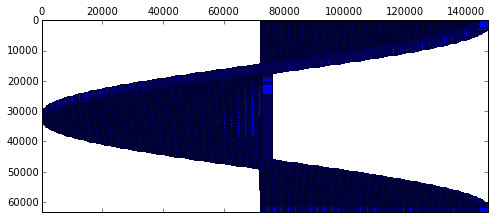

In [7]:
%matplotlib inline

plt.figure(figsize=(8,8))
plt.spy(MRI2)
plt.show()

In [ ]:
!head mri2_b.mtx

%%MatrixMarket matrix array complex general
%-------------------------------------------------------------------------------
% UF Sparse Matrix Collection, Tim Davis
% http://www.cise.ufl.edu/research/sparse/matrices/Bydder/mri2
% name: Bydder/mri2 : b matrix
%-------------------------------------------------------------------------------
63240 1
-.07214859127998352 .037707749754190445
-.0729086771607399 .03763720765709877
-.07373382151126862 .03766685724258423


In [ ]:
r_vals, i_vals = np.loadtxt("mri2_b.mtx", skiprows=7, unpack=True)

%time solution = spspla.lsqr(MRI2, r_vals + 1j*i_vals)

from scipy.fftpack import fft2, fftshift

img = solution[0].reshape(384,384)
img = np.abs(fftshift(fft2(img)))

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

In [ ]:
m = np.array([56., 56., 56., 54., 54., 53.])
k = np.array([561., 562., 560., 541., 542., 530.])

def Axv(v):
    global k, m
    w = v.copy()
    w[0] = (k[1]*v[1] - (k[0]+k[1])*v[0])/m[0]
    for j in range(1, len(v)-1):
        w[j] = k[j]*v[j-1] + k[j+1]*v[j+1] - (k[j]+k[j+1])*v[j]
        w[j] /= m[j]
        w[-1] = k[-1]*(v[-2]-v[-1])/m[-1]
    return w

A = spspla.LinearOperator((6,6), matvec=Axv, matmat=Axv, dtype=np.float64)

In [ ]:
def Cxv(v):
    n = len(v)/2
    w = v.copy()
    w[:n] = v[n:]
    w[n:] = A * v[:n]
    return w

C = spspla.LinearOperator((12,12), matvec=Cxv, matmat=Cxv, dtype=np.float64)

In [ ]:
initial_condition = np.zeros(12)
initial_condition[6:] = 1

Y = spspla.expm_multiply(C.matmat(np.eye(12)), np.ones(12), start=0, stop=1, num=10)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(np.linspace(0,1,10), Y[:,0])
plt.xlabel('time (in seconds)')
plt.ylabel('oscillation')
plt.show()

In [ ]:
blas_norm = spla.get_blas_funcs('nrm2')

blas_norm(np.float32([1e20]))

In [ ]:
A = np.array([[1,2],[4,16]])
A

In [ ]:
B = np.fromfunction(lambda i,j: (i-1)*(j+1), (3,2), dtype=int)
print B

In [ ]:
np.diag((1j,4))

In [ ]:
np.empty_like(A)

In [ ]:
print spla.pascal(13, kind='lower')

In [ ]:
np.tile(A, (2,3))   # 2 rows, 3 columns

In [ ]:
spla.block_diag(A,B)

In [ ]:
C = np.matrix('1,2;4,16')
C

In [ ]:
np.asmatrix(A)

In [ ]:
np.bmat('A;B') 

In [ ]:
np.bmat('A,C;C,A')

In [ ]:
A_coo = spsp.coo_matrix(A)
A_lil = spsp.lil_matrix(A)

In [ ]:
A_csr = spsp.csr_matrix(A_coo)

In [ ]:
M_bsr = spsp.bsr_matrix((100,100), dtype=int)

In [ ]:
M_lil = spsp.lil_matrix((100,100), dtype=int)
M_lil[25:75, 25:75] = 1

In [ ]:
M_bsr[25:75, 25:75] = 1

In [ ]:
M_dok = spsp.dok_matrix((100,100), dtype=int)

position = lambda i, j: ((i<j) & ((i+j)%10==0))

for i in range(100):
    for j in range(100):
        M_dok[i,j] = position(i,j)

In [ ]:
! cat football.rb

In [ ]:
f = open("football.rb", 'r')
football_list = list(f)
f.close()

football_data = np.array([])

for line in range(4, 4+12):
    newdata = np.fromstring(football_list[line], sep=" ")
    football_data = np.append(football_data, newdata)
    
indptr  = football_data[:35+1] - 1
indices = football_data[35+1:35+1+118] - 1
data    = football_data[35+1+118:]

football = spsp.csr_matrix((data, indices, indptr), shape=(35,35))

In [ ]:
import networkx

G = networkx.DiGraph(football)

f = open("football_nodename.txt")
m = list(f)
f.close()

def rename(x): return m[x]

G = networkx.relabel_nodes(G, rename, copy=True)
pos = networkx.spring_layout(G)  

plt.figure(figsize=(8,8))
networkx.draw_networkx(G, pos, alpha=0.2, node_color='k', edge_color='b')
plt.show()

In [ ]:
diagonals = [[1]*14, [2]*13]

print spsp.diags(diagonals, [0,-1]).todense()

In [ ]:
S_25_lil = spsp.rand(5, 5, density=0.25, format='lil')  
S_25_lil

In [ ]:
print S_25_lil

In [ ]:
print S_25_lil.todense()

In [ ]:
H1 = np.matrix("1,3,5; 2,4,6; 6,4,2; 5,3,1")
H2 = np.matrix("1,2,3; 1,3,2; 2,1,3; 2,3,1") 

def L1(x): return H1.dot(x)
def L2(x): return H2.dot(x)

print L1(np.ones(3))

In [ ]:
print L2(np.tri(3,3))

In [ ]:
L1 + L2

In [ ]:
Lo1 = spspla.aslinearoperator(H1)
Lo2 = spspla.aslinearoperator(H2)

Lo1 - 6 * Lo2

In [ ]:
print Lo1 * np.ones(3)

In [ ]:
print (Lo1-6*Lo2) * np.tri(3,3)

In [ ]:
P_sparse = spsp.diags([[1]*512, [1]*512], [512,-512], dtype=int)

P_dense = P_sparse.todense()

def mv(v): return np.roll(v, len(v)/2)

P_lo = spspla.LinearOperator((1024,1024), matvec=mv, matmat=mv, dtype=int) 

In [ ]:
%timeit P_sparse * np.ones(1024)

In [ ]:
%timeit P_dense.dot(np.ones(1024))

In [ ]:
%timeit P_lo * np.ones(1024)

In [ ]:
2*A

In [ ]:
A + 2*A

In [ ]:
A.dot(2*A)

In [ ]:
np.dot(A, 2*A)

In [ ]:
A.dot(B)

In [ ]:
B.dot(A)

In [ ]:
np.dot(B, A)

In [ ]:
C * B

In [ ]:
B * C

In [ ]:
S_10_coo = spsp.rand(5, 5, density=0.1, format='coo')

S_25_lil + S_10_coo

In [ ]:
S_25_lil * S_10_coo

In [ ]:
S_100_coo = spsp.rand(2, 2, density=1, format='coo')

np.dot(A, S_100_coo) 

In [ ]:
A * S_100_coo

In [ ]:
A.trace()

In [ ]:
C.trace()

In [ ]:
B.trace()

In [ ]:
np.trace(B, offset=-1)

In [ ]:
spla.det(C)

In [ ]:
B.transpose()

In [ ]:
C.T

In [ ]:
D = C * np.diag((1j,4))
print D

In [ ]:
print D.H

In [ ]:
E = spsp.rand(512, 512, density=1).todense()

S_100_csc = spsp.rand(512, 512, density=1, format='csc')

%timeit E.I

In [ ]:
%timeit spspla.inv(S_100_csc)

In [ ]:
spspla.inv(S_100_coo)

In [ ]:
F = E + E.T     # F is symmetric

%timeit F.I

In [ ]:
%timeit spla.inv(F)

In [ ]:
%timeit spla.pinvh(E)

In [ ]:
%timeit spla.pinv2(E)

In [ ]:
%timeit spla.pinv(F)

In [ ]:
[spla.norm(A,s) for s in (np.inf,-np.inf,-1,1,-2,2,'fro')]

In [ ]:
spla.norm(S_100_csc.todense(), 1) - spspla.onenormest(S_100_csc)

In [ ]:
a = np.float64([1e20])
b = np.float32([1e20])

[np.linalg.norm(a), spla.norm(a)]

In [ ]:
np.linalg.norm(b)

In [ ]:
spla.norm(b)

In [ ]:
np.linalg.cond(C, -np.inf)

In [ ]:
def square(x): return x**2

A = spla.hilbert(4)
print A

In [ ]:
print square(A)

In [ ]:
print A*A 

In [ ]:
print A**2

In [ ]:
print A.dot(A)

In [ ]:
print np.linalg.matrix_power(A, 2)

In [ ]:
print spla.fractional_matrix_power(A, 2)

In [ ]:
print spla.funm(A, square)

In [ ]:
A = (spla.pascal(1024, kind='lower')%2 != 0)

%timeit spla.solve_triangular(A, np.ones(1024))

In [ ]:
B_banded = np.zeros((2,6))
B_banded[0,1:] = -1
B_banded[1,:] = 2

spla.solveh_banded(B_banded, np.ones(6))

In [ ]:
C_banded = np.zeros((4,6))
C_banded[0,1:] = -1
C_banded[1,:] = 2
C_banded[2,:-1] = -1
C_banded[3,:-2] = 3

print C_banded

In [ ]:
spla.solve_banded((2,1), C_banded, np.ones(6))

In [ ]:
B = spsp.diags([[-1]*5, [2]*6, [-1]*5], [-1,0,1]).todense()
print B

In [ ]:
print spla.cholesky(B)

In [ ]:
print spla.cho_factor(B)[0]

In [ ]:
print spla.cholesky_banded(B_banded)

In [ ]:
spla.cho_solve((spla.cholesky(B), False), np.ones(6))

In [ ]:
spla.cho_solve(spla.cho_factor(B), np.ones(6))

In [ ]:
D = spla.circulant(np.arange(4096))
%timeit spla.lu(D)

In [ ]:
%timeit spla.lu_factor(D)

In [ ]:
P, L, U = spla.lu(D)

PL, U = spla.lu(D, permute_l=True)

In [ ]:
LU, piv = spla.lu_factor(D)

In [ ]:
spla.lu_solve(spla.lu_factor(D), np.ones(4096))

In [ ]:
A_csc = spsp.csc_matrix(A, dtype=np.float64)   

invA = spspla.splu(A_csc)

%time invA.solve(np.ones(1024))

In [ ]:
invA = spspla.spilu(A_csc)

%time invA.solve(np.ones(1024))

In [ ]:
spspla.cg(A_csc, np.ones(1024), x0=np.zeros(1024))

In [ ]:
%time spspla.gmres(A_csc, np.ones(1024), x0=np.zeros(1024))

In [ ]:
Nsteps = 1

def callbackF(xk):
    global Nsteps
    print'{0:4d}  {1:3.6f}  {2:3.6f}'.format(Nsteps, xk[0], xk[1])
    Nsteps += 1
    
print '{0:4s}  {1:9s}  {1:9s}'.format('Iter', 'X[0]','X[1]')

spspla.bicg(A_csc, np.ones(1024), x0=np.zeros(1024), callback=callbackF)

In [ ]:
E = D[:512,:256]; b = np.ones(512)

sol1 = np.dot(spla.pinv2(E), b)

sol2 = spla.solve(np.dot(E.T, E), np.dot(E.T, b))

In [ ]:
Q, R = spla.qr(E)
RR = R[:256, :256]
BB = np.dot(Q.T, b)[:256]

sol3 = spla.solve_triangular(RR, BB)

Q, R = spla.qr(E, mode='economic')

sol3 = spla.solve_triangular(R, np.dot(Q.T, b))

In [ ]:
U, s, Vh = spla.svd(E)
Uh = U.T
Si = spla.diagsvd(1./s, 256, 256)
V = Vh.T

sol4 = np.dot(V, Si).dot(np.dot(Uh, b)[:256])   

U, s, Vh = spla.svd(E, full_matrices=False)
Uh = U.T
Si = spla.diagsvd(1./s, 256, 256)
V = Vh.T

sol4 = np.dot(V, Si).dot(np.dot(Uh, b))

In [ ]:
sol5, residue, rank, s = spla.lstsq(E, b)

In [ ]:
map(lambda x: np.allclose(sol5, x), [sol1, sol2, sol3, sol4])

In [ ]:
np.set_printoptions(suppress=True, precision=6)
rows, cols, data = np.loadtxt("Andrews.mtx", skiprows=14, unpack=True)
rows-=1
cols-=1

A = spsp.csc_matrix((data, (rows, cols)), shape=(60000,60000))
A = A + spsp.tril(A, k=1).transpose()

In [ ]:
%time eigvals, v = spspla.eigsh(A, 5, which='LM')
print eigvals

In [ ]:
%time eigvals, v = spspla.eigsh(A, 5, which='SM')
print eigvals

In [ ]:
A = spspla.aslinearoperator(A)

%time spspla.eigsh(A, 5, sigma=10.0, mode='cayley')
print eigvals